### In this notebook, Upsampling with Neural Network is used.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df_train = pd.read_csv("/content/drive/My Drive/Humana Case Competition/2020_Competition_Training (1).csv")
df_train["train"] = 1
df_test = pd.read_csv("/content/drive/My Drive/Humana Case Competition/2020_Competition_Holdout .csv")
df_test["train"] = 0
df_test["transportation_issues"] = "NA"
df = pd.concat([df_train, df_test])
df.reset_index(inplace=True)

df.shape #87253 rows with 828 features
#df.drop("person_id_syn", axis=1, inplace=True)
#df= pd.get_dummies(df)
#df.fillna(0,inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (80,193) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (79) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(87253, 828)

In [4]:
#df.to_csv("merge_data.csv")

In [5]:
df_columns = df.columns.tolist()
df_columns.remove("transportation_issues")
#Columns with missing value
columns_with_missing = []
for column in df_columns:
    if df[column].isnull().sum()>0:
        columns_with_missing.append({"column":column, "missing":df[column].isnull().sum()})
df_missing_distribution = pd.DataFrame.from_dict(columns_with_missing)
df_missing_distribution.sort_values("missing",ascending=False).reset_index(inplace=True)
df_missing_distribution.to_csv("missing_value.csv")
from sklearn.impute import SimpleImputer
# rank 1 blood fat screen or control
# rank 2 data from cons about demos
# rank 3 cms data insurance factor data.
imputer_frequent = SimpleImputer(strategy="most_frequent")
for column in df_missing_distribution["column"]:
    try:
        if df[column].nunique()>=30:
            df[column].fillna(df[column].mean(),inplace=True)
        else:
            df[column].fillna(df[column].value_counts().index[0],inplace=True)
    except:
        print(column)

In [6]:
df_train = df[df["train"]==1]
df_train.dropna(axis=1,inplace=True)
df_hold = df[df["train"]==0]

y = df_train["transportation_issues"]
y = y.astype("int")
x = df_train.drop(["index","person_id_syn"], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [8]:
from sklearn.utils import resample
X = x_train.copy()
X["transportation_issues"] = y_train
# separate minority and majority classes
wo_tran = X[X["transportation_issues"]==0]
tran = X[X["transportation_issues"]==1]

# upsample minority
tran_upsampled = resample(tran,
                          replace=True, # sample with replacement
                          n_samples=len(wo_tran), # match number in majority class
                          random_state=42) # reproducible results

upsampled = pd.concat([wo_tran,tran_upsampled])

# check new class counts
upsampled["transportation_issues"].value_counts()

1    41536
0    41536
Name: transportation_issues, dtype: int64

In [9]:
y_train = upsampled["transportation_issues"]
x_train = upsampled.drop("transportation_issues",axis=1)
x_train = pd.get_dummies(x_train)

x_test.drop("transportation_issues",axis=1, inplace=True)
x_test = pd.get_dummies(x_test)
x_train,x_test = x_train.align(x_test, join="left", axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
# evaluate pca with logistic regression algorithm for classification
from sklearn.preprocessing import StandardScaler
# define transform
scaler = StandardScaler()
x_train = x_train.values
x_train = scaler.fit_transform(x_train)
x_test = x_test.values
x_test = scaler.fit_transform(x_test)
x_test[np.isnan(x_test)] = 0

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


### Neural Network

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Build the neural network
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu')) # Hidden 1
model.add(Dense(32, activation='relu')) # Hidden 2
model.add(Dense(16,activation='sigmoid')) #Hidden 3
model.add(Dense(1)) # Output
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
monitor = EarlyStopping(monitor='loss', min_delta=1e-1, 
                        patience=5, verbose=1, mode='auto', 
                        restore_best_weights=True)
model.fit(x_train,y_train,callbacks=[monitor],verbose=2,epochs=100)

Epoch 1/100
2596/2596 - 5s - loss: 0.6518 - accuracy: 0.6990
Epoch 2/100
2596/2596 - 5s - loss: 0.5311 - accuracy: 0.7584
Epoch 3/100
2596/2596 - 5s - loss: 0.5139 - accuracy: 0.7741
Epoch 4/100
2596/2596 - 5s - loss: 0.4319 - accuracy: 0.8179
Epoch 5/100
2596/2596 - 5s - loss: 0.4567 - accuracy: 0.8207
Epoch 6/100
2596/2596 - 5s - loss: 0.3845 - accuracy: 0.8538
Epoch 7/100
2596/2596 - 5s - loss: 0.4688 - accuracy: 0.8295
Epoch 8/100
2596/2596 - 5s - loss: 0.3578 - accuracy: 0.8675
Epoch 9/100
2596/2596 - 5s - loss: 0.3378 - accuracy: 0.8808
Epoch 10/100
2596/2596 - 5s - loss: 0.3858 - accuracy: 0.8619
Epoch 11/100
Restoring model weights from the end of the best epoch.
2596/2596 - 5s - loss: 0.3826 - accuracy: 0.8525
Epoch 00011: early stopping


In [62]:
y_prob = model.predict(x_test)

In [63]:
y_pred = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [65]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[14424  3415]
 [ 1925  1108]]


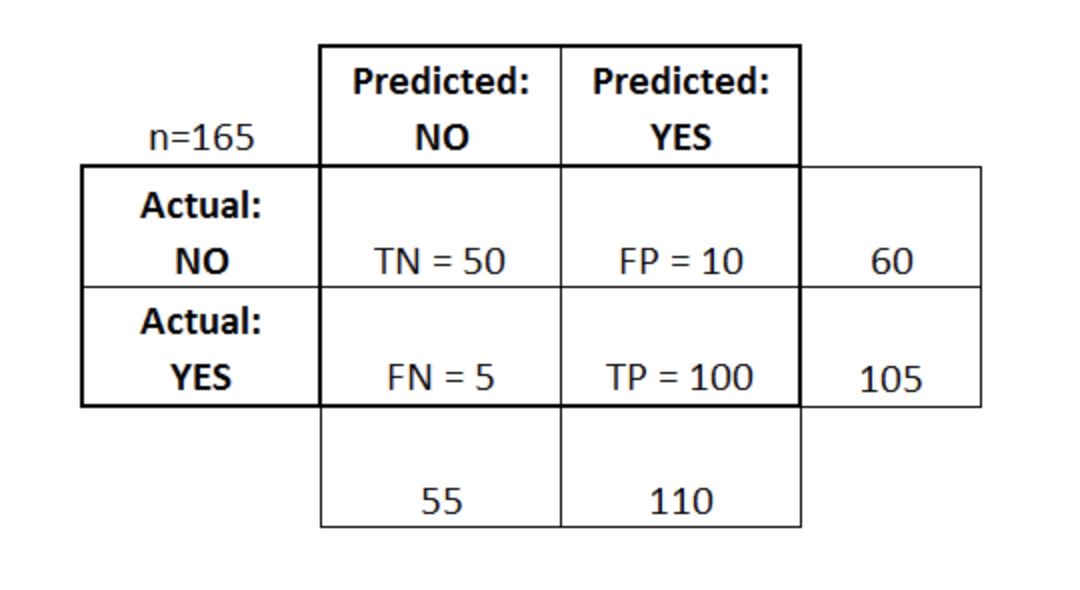

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.6134984849189697

ROC_AUC Score:
0.6134984849189697


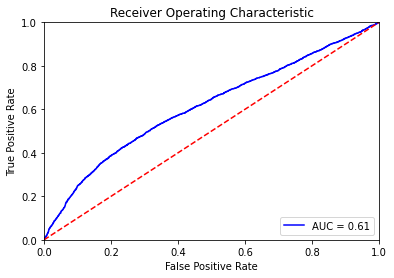

In [52]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

print("ROC_AUC Score:")
print(roc_auc_score(y_test, y_pred))

#ROC Plot
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()